In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from ipywidgets import interact

from scipy.interpolate import UnivariateSpline

from tqdm import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [14]:
rmax = 0.1

N_rings = 100
N_sectors = 360

dr = rmax/N_rings
rs = np.linspace(dr, rmax, N_rings) - dr/2
dphi = 2*np.pi/N_sectors
phis = np.linspace(0, 2*np.pi-dphi, N_sectors)

A_sectors = (rs+dr/2)**2 * np.pi/N_sectors
A_sector_rings = np.diff(A_sectors)
A_sector_rings = np.insert(A_sector_rings, 0, A_sectors[0])

In [9]:
def flux(rs, phis, As, pos, B):
    posx, posy = pos

    N_r = rs.shape[0]
    N_s = phis.shape[0]

    rs2d = np.reshape(rs, (N_r, 1))
    phis2d = np.reshape(phis, (1, N_s))

    xs = posx + rs2d * np.cos(phis2d)
    ys = posy + rs2d * np.sin(phis2d)
    return (np.reshape(As, (N_r, 1))*B(xs, ys)).sum()

In [10]:
def B(x, y):
    B0 = 10
    return (x>0) * B0 * x

In [11]:
def Forces(rvecs, Is, pos, B):

    dls = np.diff(rvecs, axis=1)
    dls = np.append(dls, np.reshape(rvecs[:, 0]-rvecs[:, -1], (N_rings, 1, 3)), axis=1)

    x = (rvecs + dls/2 + pos)[:, :, 0]
    y = (rvecs + dls/2 + pos)[:, :, 1]
    
    Bvec = np.concatenate((np.zeros((2*N_rings, N_sectors)), B(x, y)))
    Bvec = np.reshape(Bvec, (3, N_rings, N_sectors))
    Bvec = np.moveaxis(Bvec, 0, 2)

    Fs = (np.reshape(Is, (N_rings, 1, 1)) * np.cross(dls, Bvec)).sum(axis=1)

    return Fs

In [26]:
rhom = 8.92e3 # mass density of copper
rho = 1.7e-8 # resistivity of copper
h = 1e-3 # thickness of plate

m = rhom * rmax*rmax*np.pi * h # mass of copper plate

x0 = -0.11 # initial position of plate
v0 = 0.2 # initial velocity in x direction

# define time and position arrays
N_steps = 100 # number of steps for simulation
tmax = 1 # time range for simulation
dt = tmax/N_steps
t = np.linspace(0, tmax, N_steps)

# define quantities for calculation of force
x = np.zeros(N_steps) # define empty array for positions
vx = np.zeros(N_steps) # define empty array for velocities
Fx = np.zeros((N_steps, 3)) # define empty array for forces

x[0] = x0 # initial position
vx[0] = v0 # initial velocity
flux0 = np.array([flux(rs[0:i+1], phis, A_sector_rings[0:i+1], (x0, 0), B) for i in range(N_rings)])

Rs = rho*2*np.pi*rs/(dr*h) # resistance of rings

# define vectors for segments
rxs = [r * np.cos(phis) for r in rs]
rys = [r * np.sin(phis) for r in rs]
rzs = np.zeros((N_rings, N_sectors))

r_vecs = np.moveaxis(np.array([rxs, rys, rzs]), 0, 2)

# loop to calculate positions
for i in tqdm(range(N_steps-1)):
    fluxi = np.array([flux(rs[0:n+1], phis, A_sector_rings[0:n+1], (x[i], 0), B) for n in range(N_rings)])

    Eis = -(fluxi-flux0)/dt # induced emf (Faraday's law)
    flux0 = fluxi
    Is = Eis/Rs # calculate currents through rings

    Fs = Forces(r_vecs, Is, (x[i], 0, 0), B)
    Fx[i] = Fs.sum(axis=0)
    
    ax = Fx[i, 0]/m # acceleration in x direction
    
    vx[i+1] = vx[i] + ax*dt
    x[i+1] = x[i] + vx[i+1]*dt

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:01<00:00, 87.19it/s]


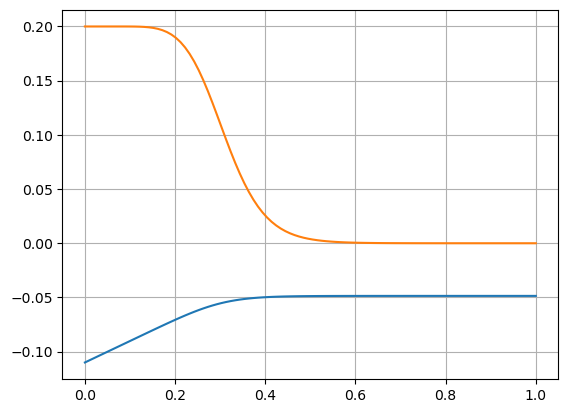

In [27]:
plt.plot(t, x)
plt.plot(t, vx)
plt.grid()

In [28]:
x[-1]

-0.0485671745591094

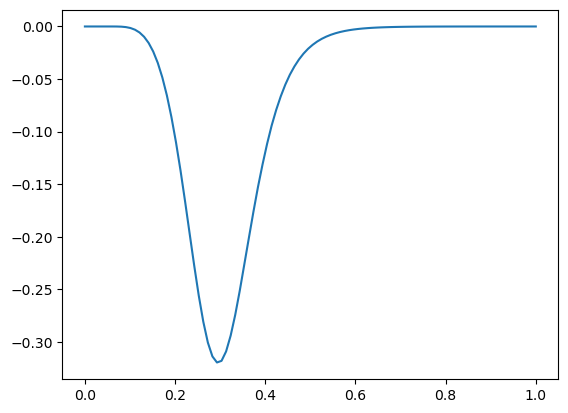

In [29]:
plt.plot(t, Fx[:, 0])